In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 24 07:49:46 2021

@author: hwicaksono
"""

"""
Regression
"""

#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import warnings
warnings.simplefilter('ignore')

# Functions for later reuses

In [2]:
# Function to calculate metrics
def calculate_metrics(df, method, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    df.loc[method] = [mae, mse, rmse]

In [3]:
# Function to calculate cross validation
def calculate_cross_validation_scores (df, model, method, X, y):
    my_cv = 10
    mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=my_cv).mean()
    mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=my_cv).mean()
    rmse = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=my_cv).mean()
    df.loc[method] = [mae, mse, rmse]

In [4]:
# Visualize the training set, test set, and result
def plot_regression(regressor, method, X_train, X_test, y_test):
    plt.figure(figsize=(10, 10))
    plt.scatter(X_train,y_train, color = 'red')
    plt.scatter(X_test,y_test, color = 'green')
    plt.plot(X_train, regressor.predict(X_train), color = 'blue')
    plt.title(str(method))
    plt.xlabel('km')
    plt.ylabel('price')
    plt.show()

In [5]:
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
def plot_smoother_regression(regressor, method, X_train, X_test, y_test):
    plt.figure(figsize=(10, 10))
    X_grid = np.arange(min(X_train), max(X_train), 0.1)
    X_grid = X_grid.reshape((len(X_grid), 1))
    plt.scatter(X_train, y_train, color = 'red')
    plt.scatter(X_test, y_test, color = 'green')
    plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
    plt.title(method)
    plt.xlabel('km')
    plt.ylabel('price')
    plt.show()

# Data import and exploration

In [6]:
#Import the dataset
dataset = pd.read_csv(r'..\Datasets\gebrauchtwagen.csv')
dataset

,km,yearto2019,owner,price
0,36599,7,1,6190
1,57000,6,2,6900
2,102350,3,1,7222
3,65300,5,1,7500
4,28053,4,1,7749
5,56467,4,1,7912
6,46300,3,1,8490
7,20990,2,1,8690
8,95000,1,1,8760
9,17940,0,1,10490


In [7]:
# Find missing values
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)

,column_name,percent_missing
km,km,0.0
yearto2019,yearto2019,0.0
owner,owner,0.0
price,price,0.0


In [8]:
# Count unique values of all categorical columns
categorical_cols = ['owner']
cat_cols_unique_counts_df = pd.DataFrame(columns = ['UniqueValuesCount'], index = categorical_cols)
for col in categorical_cols:
    cat_cols_unique_counts_df.loc[col] = dataset[col].nunique()
display(cat_cols_unique_counts_df)

,UniqueValuesCount
owner,2


<Figure size 720x720 with 0 Axes>

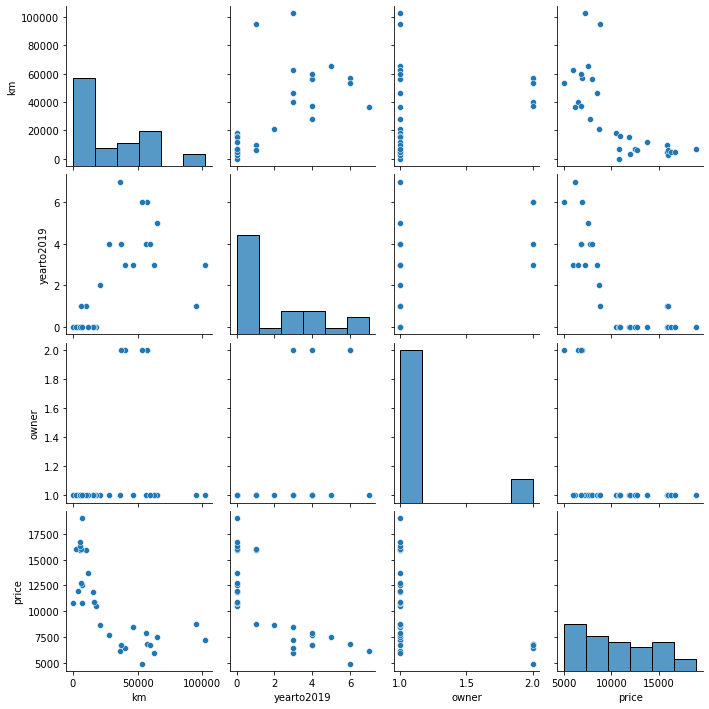

In [9]:
# Exploratory data analytics
plt.figure(figsize=(10, 10))
sns.pairplot(dataset)
plt.show()

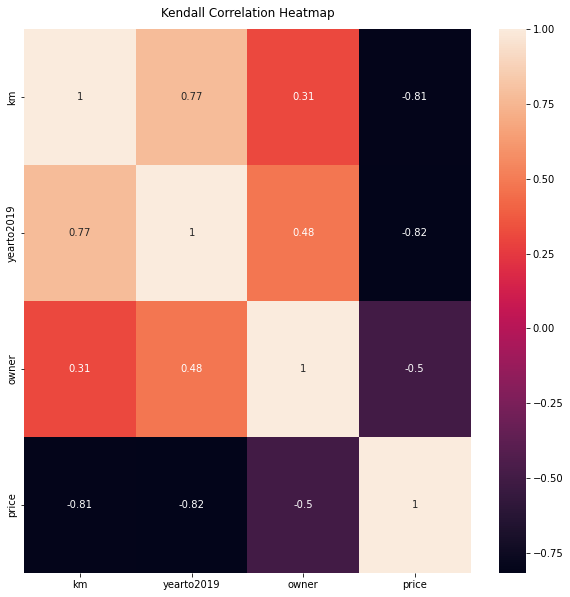

In [10]:
# Draw the correlation heatmaps using seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(dataset.corr(method='spearman'), annot=True)
heatmap.set_title('Kendall Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

# Get X and y, and then split the data

In [11]:
# Get X (independent variables) and y (dependent variable)
# km as independent variable
X = dataset.iloc[:, 0:1].values
# price as dependent variable
y = dataset.iloc[:, 3].values
display(pd.DataFrame(X))
display(pd.DataFrame(y))

,0
0,36599
1,57000
2,102350
3,65300
4,28053
5,56467
6,46300
7,20990
8,95000
9,17940


,0
0,6190
1,6900
2,7222
3,7500
4,7749
5,7912
6,8490
7,8690
8,8760
9,10490


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Create Dataframes for evaluation

In [13]:
methods = ['Linear Regression', 'Multiple Linear Regression', 'Polynomial Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression', 'KNN Regression', 'Support Vector Regression', 'PLS Regression']
quality_metrics = ['MAE', 'MSE', 'RMSE']

error_df = pd.DataFrame(columns = quality_metrics, index = methods)
display(error_df)

cv_df = pd.DataFrame(columns = quality_metrics, index = methods)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,NaN,NaN,NaN
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,NaN,NaN,NaN
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,NaN,NaN,NaN
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,NaN,NaN,NaN
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


# Linear Regression

In [14]:
# fit Simple Linear Regression to training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slopes/coefficients
print(regressor.coef_)

13873.743898017767
[-0.09698566]


In [15]:
# predict test result
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,9989.565399
1,8085.349048
2,10265.877530


In [16]:
method = 'Linear Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,NaN,NaN,NaN
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,NaN,NaN,NaN
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


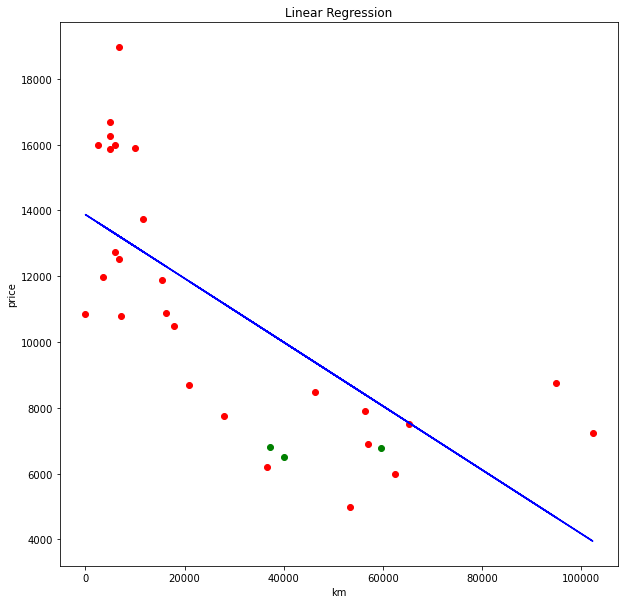

In [17]:
plot_regression(regressor, method, X_train, X_test, y_test)

# Polynomial  Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.1, random_state = 0)
poly_reg.fit(X_poly_train, y_train)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly_train, y_train)

# Predict test set result
y_pred = lin_reg_2.predict(X_poly_test)
display(pd.DataFrame(y_pred))

,0
0,4245.399049
1,6912.087330
2,12075.383820


In [19]:
method = 'Polynomial Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)

calculate_cross_validation_scores (cv_df, lin_reg_2, method, X_poly, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,NaN,NaN,NaN
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


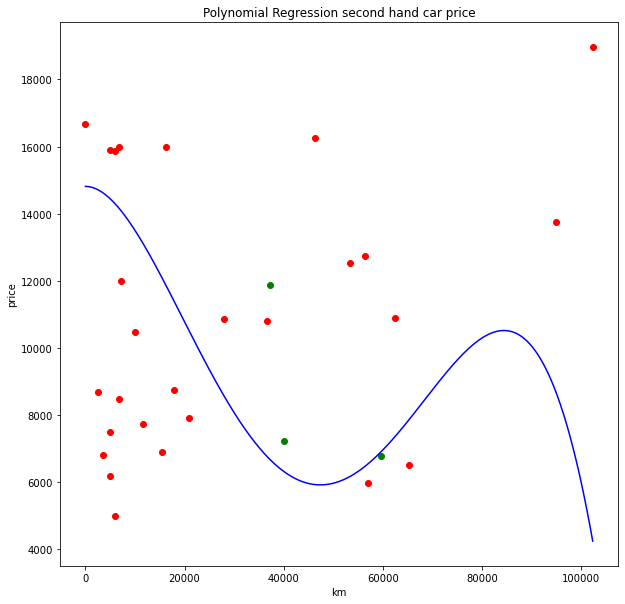

In [20]:
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
plt.figure(figsize=(10, 10))
X_grid = np.arange(min(X_train), max(X_train), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_train, y_train, color = 'red')
plt.scatter(X_test, y_test, color = 'green')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('Polynomial Regression second hand car price')
plt.xlabel('km')
plt.ylabel('price')
plt.show()

# Lasso Regression

In [25]:
#Fitting lasso regression to dataset
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# define model
model = LassoCV(cv=10)
model.fit(X,y)
print('alpha : ' + str(model.alpha_))
print('score : ' +  str(model.score(X,y)))

regressor = Lasso(alpha = model.alpha_)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

alpha : 3937973.520857092
score : 0.528530886207663


,0
0,11338.508093
1,11928.575968
2,11252.886041


In [26]:
method = 'Lasso Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,NaN,NaN,NaN
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


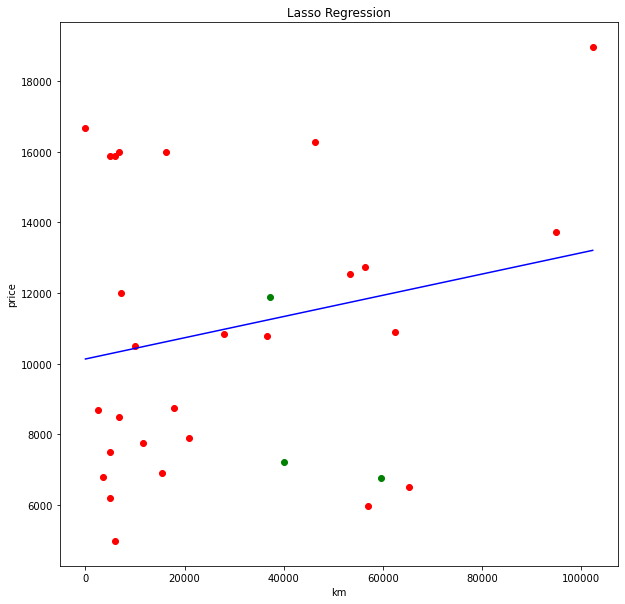

In [27]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Ridge Regression

In [31]:
# Fitting ridge regression to dataset
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV


# define model
model = RidgeCV(cv=10)
model.fit(X,y)

print('alpha : ' + str(model.alpha_))
print('score : ' + str(model.score(X,y)))

regressor = Ridge(alpha = model.alpha_)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

alpha : 0.1
score : 0.5298433486389562


,0
0,11397.331455
1,12081.221571
2,11298.095286


In [32]:
method = 'Ridge Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,NaN,NaN,NaN
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


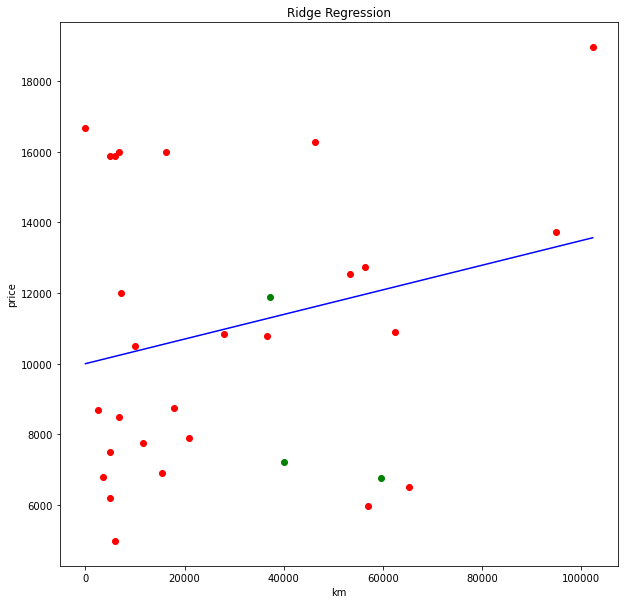

In [33]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Elastic Net Regression

In [38]:
#Fitting elastic net regression to dataset
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV


# define model
model = ElasticNetCV(cv=10)
# fit model
model.fit(X, y)

print('alpha : ' + str(model.alpha_))
print('l1 ratio : ' + str(model.l1_ratio_))
print('score : ' + str(model.score(X,y)))

regressor = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

alpha : 8445119.855119292
l1 ratio : 0.5
score : 0.5280325326079796


,0
0,11332.392829
1,11912.706964
2,11248.186097


In [39]:
method = 'Elastic Net Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,NaN,NaN,NaN
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


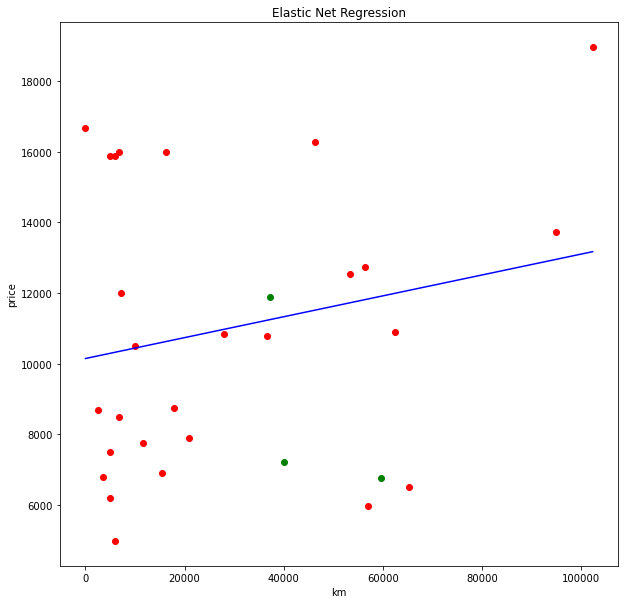

In [40]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Decision Tree Regression

In [41]:
#Fitting decision tree regression to dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split  = 2)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,10800.0
1,5980.0
2,10800.0


In [42]:
method = 'Decision Tree Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,NaN,NaN,NaN
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


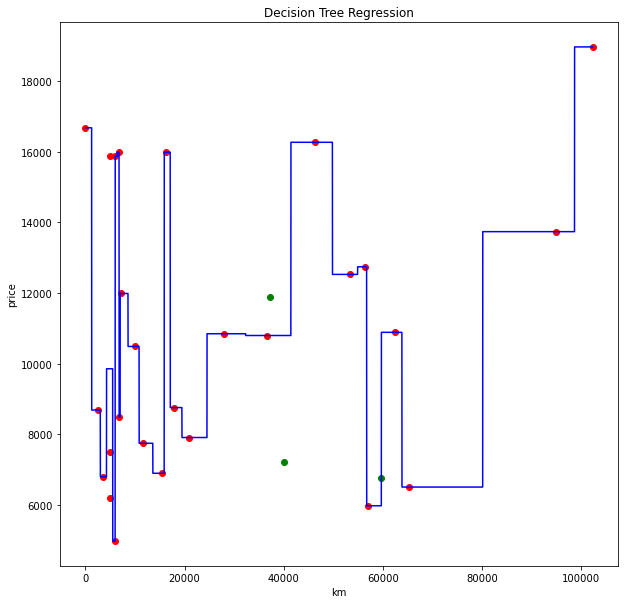

In [43]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Random Forest Regression

In [44]:
#Fitting random forest regression to dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,12319.15
1,7917.80
2,12270.82


In [45]:
method = 'Random Forest Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,2206.92,9.14398e+06,3023.9
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Gradient Boosting Regression,NaN,NaN,NaN
KNN Regression,NaN,NaN,NaN


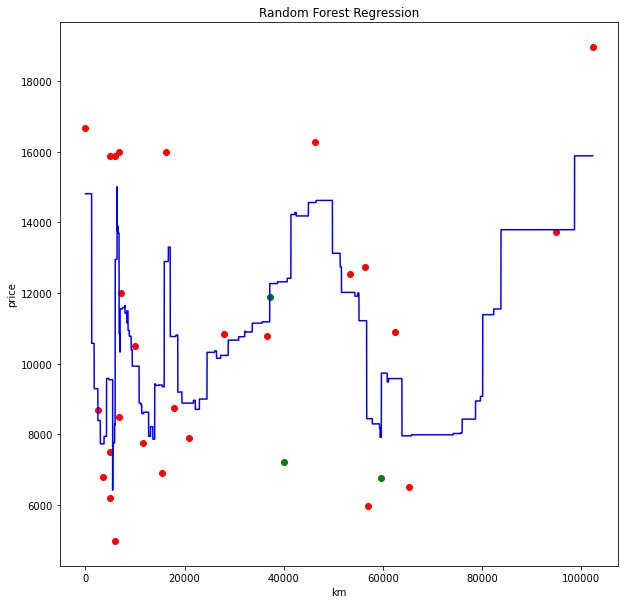

In [46]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Gradient Boosting

In [47]:
#Fitting gradient boosting regression to dataset
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(max_depth=10, n_estimators=100, learning_rate=1.0)
regressor.fit(X_train, y_train)

#prediction of new value
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,10800.0
1,5980.0
2,10800.0


In [48]:
method = 'Gradient Boosting Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,2206.92,9.14398e+06,3023.9
Gradient Boosting Regression,1821,4.87407e+06,2207.73
KNN Regression,NaN,NaN,NaN


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Gradient Boosting Regression,-1975.93,-6.84368e+06,-2313.25
KNN Regression,NaN,NaN,NaN


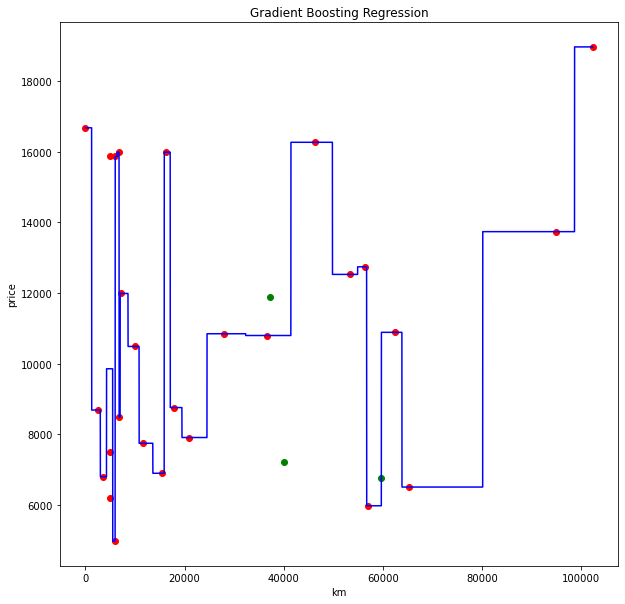

In [49]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# KNN Regression

In [50]:
# Fitting KNN regression to dataset
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=2)
regressor.fit(X_train, y_train)

# prediction of test values
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,13535.0
1,8435.0
2,13535.0


In [51]:
method = 'KNN Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,2206.92,9.14398e+06,3023.9
Gradient Boosting Regression,1821,4.87407e+06,2207.73
KNN Regression,3206,1.51052e+07,3886.54


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Gradient Boosting Regression,-1975.93,-6.84368e+06,-2313.25
KNN Regression,-1961.08,-6.85689e+06,-2320.83


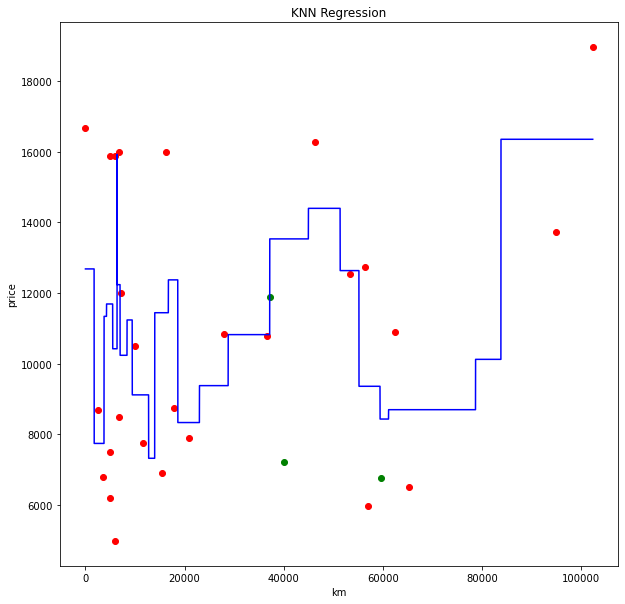

In [52]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# Support Vector Regression

In [53]:
# Fitting SVR to dataset
from sklearn.svm import SVR
regressor = SVR(kernel='linear')
regressor.fit(X_train, y_train)

#prediction of test dataset
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,10723.644922
1,12061.480719
2,10529.517684


In [54]:
method = 'Support Vector Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,2206.92,9.14398e+06,3023.9
Gradient Boosting Regression,1821,4.87407e+06,2207.73
KNN Regression,3206,1.51052e+07,3886.54


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Gradient Boosting Regression,-1975.93,-6.84368e+06,-2313.25
KNN Regression,-1961.08,-6.85689e+06,-2320.83


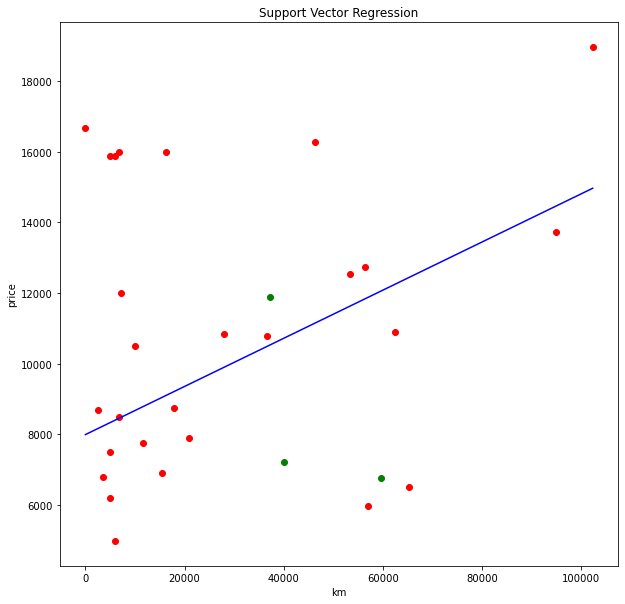

In [55]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

# PLS Regression

In [56]:
# Fitting PLS Regression to dataset
from sklearn.cross_decomposition import PLSRegression, PLSSVD
regressor = PLSRegression(n_components = 1)
regressor.fit(X_train, y_train)

#prediction of test dataset
y_pred = regressor.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,11397.331455
1,12081.221571
2,11298.095286


In [57]:
method = 'PLS Regression'
calculate_metrics(error_df, method , y_test, y_pred)
display(error_df)
calculate_cross_validation_scores (cv_df, regressor, method, X, y)
display(cv_df)

,MAE,MSE,RMSE
Linear Regression,2751.93,8.61223e+06,2934.66
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,1099.69,2.9711e+06,1723.69
Lasso Regression,3302.4,1.4637e+07,3825.83
Ridge Regression,3357.82,1.53132e+07,3913.21
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Decision Tree Regression,1821,4.87407e+06,2207.73
Random Forest Regression,2206.92,9.14398e+06,3023.9
Gradient Boosting Regression,1821,4.87407e+06,2207.73
KNN Regression,3206,1.51052e+07,3886.54


,MAE,MSE,RMSE
Linear Regression,-2547.79,-9.25296e+06,-2827.85
Multiple Linear Regression,NaN,NaN,NaN
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Gradient Boosting Regression,-1975.93,-6.84368e+06,-2313.25
KNN Regression,-1961.08,-6.85689e+06,-2320.83


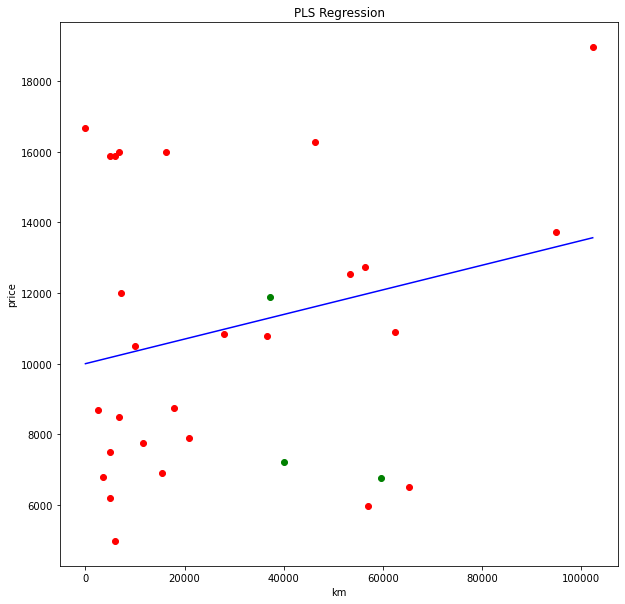

In [58]:
plot_smoother_regression(regressor, method, X_train, X_test, y_test)

In [59]:
error_df.sort_values(by=['RMSE'], inplace=True)
display(error_df)
cv_df.sort_values(by=['RMSE'], ascending=False, inplace=True)
display(cv_df)

,MAE,MSE,RMSE
Polynomial Regression,1099.69,2.9711e+06,1723.69
Decision Tree Regression,1821,4.87407e+06,2207.73
Gradient Boosting Regression,1821,4.87407e+06,2207.73
Linear Regression,2751.93,8.61223e+06,2934.66
Random Forest Regression,2206.92,9.14398e+06,3023.9
Support Vector Regression,3382.87,1.40198e+07,3744.3
Elastic Net Regression,3296.64,1.45678e+07,3816.77
Lasso Regression,3302.4,1.4637e+07,3825.83
KNN Regression,3206,1.51052e+07,3886.54
Ridge Regression,3357.82,1.53132e+07,3913.21


,MAE,MSE,RMSE
Polynomial Regression,-1807.37,-4.8754e+06,-1989.76
Random Forest Regression,-1862.52,-5.99855e+06,-2155.93
Decision Tree Regression,-1975.93,-6.84368e+06,-2313.25
Gradient Boosting Regression,-1975.93,-6.84368e+06,-2313.25
KNN Regression,-1961.08,-6.85689e+06,-2320.83
Elastic Net Regression,-2551.03,-9.21678e+06,-2810.86
Lasso Regression,-2551.33,-9.22449e+06,-2813.92
Ridge Regression,-2547.79,-9.25296e+06,-2827.85
Linear Regression,-2547.79,-9.25296e+06,-2827.85
PLS Regression,-2547.79,-9.25296e+06,-2827.85
